# Lab 4: Effect of **data augmentation** on a *shallow, linear FCN*

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_04_FCN_Augmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#### High-level overview

In the *Lab* that follows, we will explore the effect of **data augmentation** on the structure of learned weights in a *neural network* model. As an example, we will consider a *shallow, linear FCN* (fully-connected network with just 1 layer and no non-linearities) that is trained on the MNIST *classification task*.

On a high level, you need to:
- Define and train a *shallow, linear FCN* on the MNIST dataset, using *training-set augmentation* by means of *random rotations*;
- Extract the learned weights from the trained model;
- Visualize the learned weights as *images* and comment on their structure.

The rest of the notebook will guide you through more detailed steps you need to follow.

#### Loading the datasets and defining augmentation strategies

Load the (training and test) *MNIST* datasets as we did in the previous lab, with the following meaningful differences:
- Apply random rotations to the dataset used for training, using a rotation range of $[0, 180]$ degrees.
- Apply normalization to both datasets, using a mean of $0.1307$ and a standard deviation of $0.3081$ (they are notable, pre-computed values for the MNIST **training** dataset);

**Hint**: look up the documentation for the `transforms.RandomRotation` and `transforms.Normalize` classes.

**Optional**: Visualize the augmented training dataset, to get a sense of the effect of the augmentation strategy.

In [24]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor  # For type annotations

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# add to data transform random rotations between 0 and 180 degrees, normalize the data with mean 0,1307, and std 0.3081
data_transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-90, 90)), 
    transforms.Normalize((0.1307,), (0.3081,))
])

data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=data_transforms_train, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=data_transforms_test, download=True
)

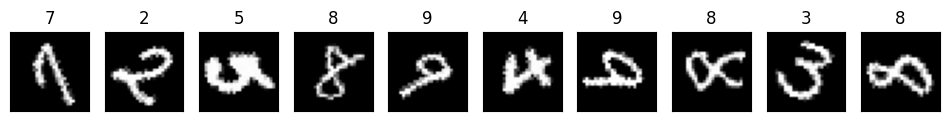

In [22]:
# visualize the training data
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(image.squeeze(), cmap="gray")
    axes[idx].set_title(labels[idx].item())
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
plt.show()

#### Model definition and training

Define the model and train it on the classification task, as we did in the previous *Lab*. Use fixed-learning-rate *Stochastic Gradient Descent* (with no momentum) as the optimizer. Feel free to experiment with the other hyperparameters.

**Optional**: Plot the training loss as the training progresses. Show also test loss at the beginning and at the end of training.


In [44]:
# define a NN with 1 linear layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
    
        return F.log_softmax(x, dim=1)
    
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 5

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.NLLLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in tqdm(range(EPOCHS)):
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    model.to(device)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        log_logits = model(images)
        _, predicted = torch.max(log_logits, 1)
        train_acc += (predicted == labels).sum().item()

        loss = criterion(log_logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()

    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            log_logits = model(images)
            _, predicted = torch.max(log_logits, 1)
            test_acc += (predicted == labels).sum().item()

    train_acc /= len(train_dataset)
    test_acc /= len(test_dataset)

    print(
        f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%"
    )

 20%|██        | 1/5 [00:32<02:08, 32.02s/it]

Epoch: 1 | Loss: 8.405114756944853 | Train Accuracy: 55.44%, Test Accuracy: 69.87%


 40%|████      | 2/5 [01:03<01:35, 31.79s/it]

Epoch: 2 | Loss: 6.601990586481033 | Train Accuracy: 64.67%, Test Accuracy: 71.78%


 60%|██████    | 3/5 [01:35<01:03, 31.81s/it]

Epoch: 3 | Loss: 6.278858767870145 | Train Accuracy: 66.14%, Test Accuracy: 72.97%


 80%|████████  | 4/5 [02:08<00:32, 32.39s/it]

Epoch: 4 | Loss: 6.114872837295899 | Train Accuracy: 67.20%, Test Accuracy: 73.75%


100%|██████████| 5/5 [02:40<00:00, 32.13s/it]

Epoch: 5 | Loss: 6.015047093327993 | Train Accuracy: 67.73%, Test Accuracy: 73.38%


#### Weights extraction and visualization

Extract the tensors corresponding to learned weights from the trained model (they are stored as the `weights` attribute of the linear layer), and visualize them as images.

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.

**Remark**: in order to be able to visualize the weights as images, they need to be appropriately scaled (as tensor) within the $[0,1]$ range.


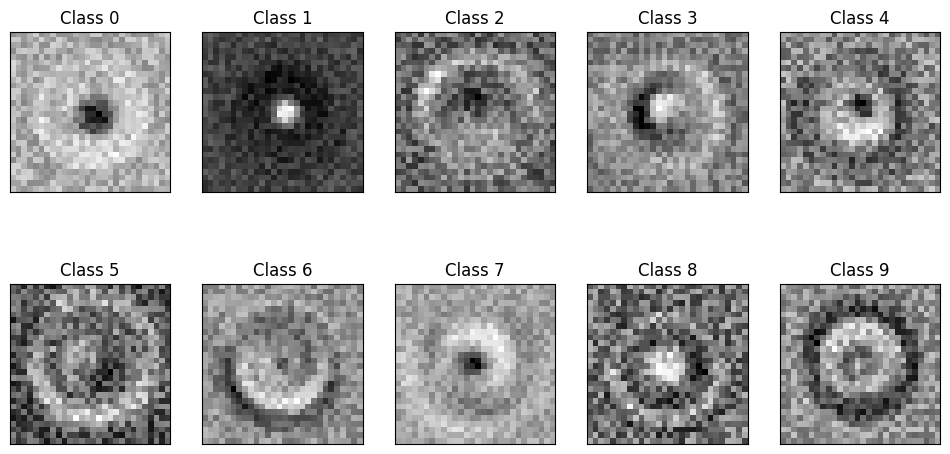

In [45]:
# Extract the weights from the trained model
weights = model.fc1.weight.data

# Normalize the weights to the [0,1] range
min_weight = weights.min()
max_weight = weights.max()
normalized_weights = (weights - min_weight) / (max_weight - min_weight)

# Reshape the weights into the form of 28x28 images
weights_images = normalized_weights.view(10, 28, 28)

# Visualize the weights as images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(weights_images[i].cpu().numpy(), cmap='gray')
    ax.set_title(f'Class {i}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

#### Optional I: Training with different augmentation strategies

Repeat the same process described above, but using different augmentation strategy, namely:
- Apply a central (vertical or horizontal, one only or both) flip to images in the training dataset;
- Apply random translations to images in the training dataset, bound by an arbitrary maximum;

Comment on the structure of the learned weights, in relation to the nature of the augmentation strategy.


In [46]:
# Define the new data transform with central flips and random translations
data_transforms_train = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),  # Randomly apply vertical flip
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly apply horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test data transform remains the same
data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=data_transforms_train, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=data_transforms_test, download=True
)

In [49]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
for epoch in tqdm(range(EPOCHS)):
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    model.to(device)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        log_logits = model(images)
        _, predicted = torch.max(log_logits, 1)
        train_acc += (predicted == labels).sum().item()

        loss = criterion(log_logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()

    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            log_logits = model(images)
            _, predicted = torch.max(log_logits, 1)
            test_acc += (predicted == labels).sum().item()

    train_acc /= len(train_dataset)
    test_acc /= len(test_dataset)

    print(
        f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%"
    )

 20%|██        | 1/5 [00:21<01:27, 21.94s/it]

Epoch: 1 | Loss: 9.424633911213814 | Train Accuracy: 46.21%, Test Accuracy: 58.46%


 40%|████      | 2/5 [00:43<01:04, 21.46s/it]

Epoch: 2 | Loss: 9.39300956366918 | Train Accuracy: 46.48%, Test Accuracy: 59.12%


 60%|██████    | 3/5 [01:04<00:42, 21.30s/it]

Epoch: 3 | Loss: 9.39085798080151 | Train Accuracy: 46.66%, Test Accuracy: 59.23%


 80%|████████  | 4/5 [01:25<00:21, 21.14s/it]

Epoch: 4 | Loss: 9.360878116236282 | Train Accuracy: 47.08%, Test Accuracy: 58.15%


100%|██████████| 5/5 [01:49<00:00, 21.89s/it]

Epoch: 5 | Loss: 9.317535677781471 | Train Accuracy: 47.07%, Test Accuracy: 57.69%


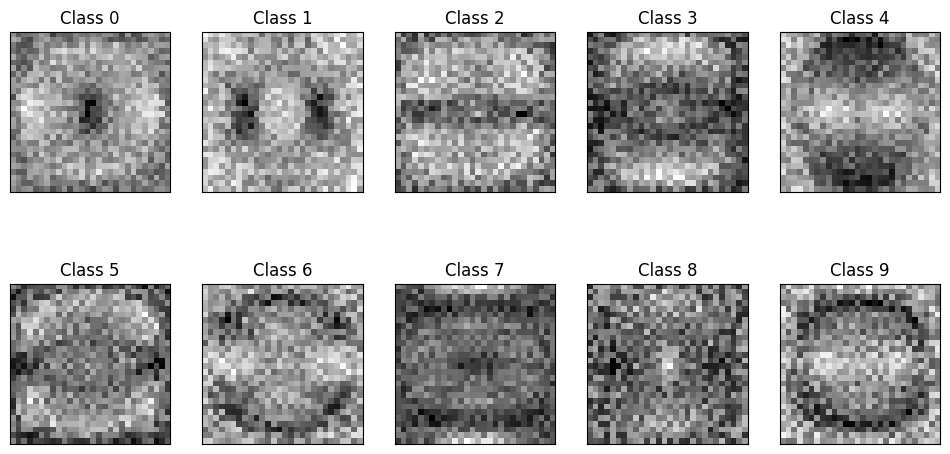

In [50]:
# Extract the weights from the trained model
weights = model.fc1.weight.data

# Normalize the weights to the [0,1] range
min_weight = weights.min()
max_weight = weights.max()
normalized_weights = (weights - min_weight) / (max_weight - min_weight)

# Reshape the weights into the form of 28x28 images
weights_images = normalized_weights.view(10, 28, 28)

# Visualize the weights as images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(weights_images[i].cpu().numpy(), cmap='gray')
    ax.set_title(f'Class {i}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


#### Optional II: Testing for the invariance of the learned representation

Test that the internal representation produced by the weights learned under data augmentation is indeed invariant to the same transformation used for data augmentation. You may follow the guidance given in [this notebook](AdvML_UniTS_2023_Lab_04bis_FCN_Invariance.ipynb).


In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 10)

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(-1, 28 * 28)
        features = self.fc1(x)
        return features, F.log_softmax(features, dim=1)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
for epoch in tqdm(range(EPOCHS)):
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    model.train()
    model.to(device)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        log_logits = model(images)[1]
        _, predicted = torch.max(log_logits, 1)
        train_acc += (predicted == labels).sum().item()

        loss = criterion(log_logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()

    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            log_logits = model(images)[1]
            _, predicted = torch.max(log_logits, 1)
            test_acc += (predicted == labels).sum().item()

    train_acc /= len(train_dataset)
    test_acc /= len(test_dataset)

    print(
        f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%"
    )


 20%|██        | 1/5 [00:21<01:24, 21.20s/it]

Epoch: 1 | Loss: 11.01886553947742 | Train Accuracy: 36.32%, Test Accuracy: 56.76%


 40%|████      | 2/5 [00:42<01:03, 21.12s/it]

Epoch: 2 | Loss: 9.886947760215172 | Train Accuracy: 43.52%, Test Accuracy: 57.75%


 60%|██████    | 3/5 [01:03<00:42, 21.18s/it]

Epoch: 3 | Loss: 9.64461435071933 | Train Accuracy: 44.83%, Test Accuracy: 57.98%


 80%|████████  | 4/5 [01:24<00:21, 21.05s/it]

Epoch: 4 | Loss: 9.54730610893323 | Train Accuracy: 45.28%, Test Accuracy: 58.17%


100%|██████████| 5/5 [01:45<00:00, 21.06s/it]

Epoch: 5 | Loss: 9.470133999219307 | Train Accuracy: 45.93%, Test Accuracy: 58.07%


In [56]:

data_transforms_test_aug = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),  # Randomly apply vertical flip
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly apply horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Create augmented test dataset
test_dataset_aug = datasets.MNIST(
    root="./data", train=False, transform=data_transforms_test_aug, download=True
)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)

# Move model to the correct device
model.to(device)

# Function to extract features
def extract_features(loader):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            features, _ = model(images)
            features_list.append(features.cpu())
            labels_list.append(labels)
    return torch.cat(features_list), torch.cat(labels_list)

# Extract features from original and augmented test datasets
features_original, labels_original = extract_features(test_loader)
features_augmented, labels_augmented = extract_features(test_loader_aug)

# Compare the internal representations
# Using cosine similarity to compare the features
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
similarities = cos(features_original, features_augmented)

# Calculate the mean similarity
mean_similarity = similarities.mean().item()

print(f'Mean cosine similarity between original and augmented features: {mean_similarity:.4f}')

Mean cosine similarity between original and augmented features: 0.8691
